In [55]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow_hub as hub
import string
from tensorflow.keras.layers import TextVectorization

Constants

In [2]:
DATA_DIR = "PubMed_20k_RCT_numbers_replaced_with_at_sign/"

GPU Check

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-effaf08f-fb7a-35f9-d18c-f97fa5346829)


# Assets

In [35]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Data loading

In [6]:
filenames = [DATA_DIR + filename for filename in os.listdir(DATA_DIR)]
print(filenames)

['PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


# Preprocessing

In [8]:
def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list.
    """
    with open(filename, "r") as f:
        return f.readlines()

In [10]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")

                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split)
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [9]:
train_lines = get_lines(DATA_DIR + "train.txt")
print(train_lines[:20])

['###24293578\n', 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n', 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n', 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n', 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n', 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n', 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-s

In [11]:
train_samples = preprocess_text_with_line_numbers(DATA_DIR + "train.txt")
val_samples = preprocess_text_with_line_numbers(DATA_DIR + "dev.txt")
test_samples = preprocess_text_with_line_numbers(DATA_DIR + "test.txt")

In [17]:
print([(i, "\n") for i in train_samples[:1]])

[({'target': 'OBJECTIVE', 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .', 'line_number': 0, 'total_lines': 12}, '\n')]


In [20]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
print(train_df.head())

      target                                               text  line_number  \
0  OBJECTIVE  to investigate the efficacy of @ weeks of dail...            0   
1    METHODS  a total of @ patients with primary knee oa wer...            1   
2    METHODS  outcome measures included pain reduction and i...            2   
3    METHODS  pain was assessed using the visual analog pain...            3   
4    METHODS  secondary outcome measures included the wester...            4   

   total_lines  
0           12  
1           12  
2           12  
3           12  
4           12  


In [21]:
print(train_df.target.value_counts())

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


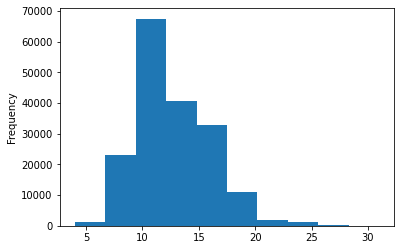

In [22]:
train_df.total_lines.plot.hist()

In [23]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [25]:
print(train_sentences[:10])

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .', 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .', 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .', 'pain was assessed using the visual analog pain scale ( @-@ mm ) .', 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .', 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .', 'there was a clinically r

In [28]:
# Encoding with one-hot encoding

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

print(train_labels_one_hot)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [30]:
# Encoding with label encoding

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

print(train_labels_encoded)

[3 2 2 ... 4 1 1]


In [31]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

# Tribid embedding model

## Positional embeddings

In [37]:
print(train_df['line_number'].value_counts())

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64


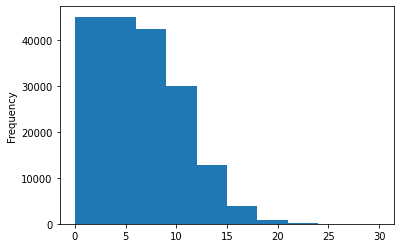

In [38]:
train_df.line_number.plot.hist()

In [39]:
# One-hot encoding of line numbers

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [40]:
print(train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20])

(180040, 15) tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]], shape=(20, 15)

In [45]:
print(train_df['total_lines'].value_counts())

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64


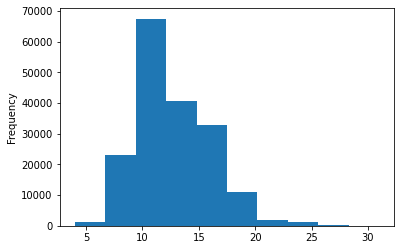

In [46]:
train_df.total_lines.plot.hist()

In [47]:
# One-hot encoding of total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

print(train_total_lines_one_hot.shape, train_total_lines_one_hot[:10])

(180040, 20) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 20), dtype=float32)


## Tribid embedding implementation

In [51]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [58]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [59]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [62]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [63]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [64]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [66]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [67]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# Character inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Line numbers inputs
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combining positional embeddings with combined token and character embeddings in a tribid embedding model
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)
tribid_embedding_model = tf.keras.Model(inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input], outputs=output_layer)

In [68]:
tribid_embedding_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

In [69]:
for layer in tribid_embedding_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6d3e770cd0> True
<keras.engine.input_layer.InputLayer object at 0x7f6cb4557f90> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f6cb5e06250> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f6d56233590> False
<keras.layers.core.embedding.Embedding object at 0x7f6d3e759650> True
<keras.layers.core.dense.Dense object at 0x7f6cb3523ad0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f6d3e7d1710> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f6d3e74d990> True
<keras.engine.input_layer.InputLayer object at 0x7f6d3e6e2b90> True
<keras.engine.input_layer.InputLayer object at 0x7f6d3e64e910> True
<keras.layers.core.dense.Dense object at 0x7f6d3e74dc10> True
<keras.layers.core.dense.Dense object at 0x7f6d3e770650> True
<keras.layers.core.dense.Dense object at 0x7f6d3e755c10> True
<keras.layers.regularization.dropout.Dropout object at 0x7f6d3e55ed90> True
<keras.layers

In [70]:
tribid_embedding_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                               optimizer=tf.keras.optimizers.Adam(),
                               metrics=["accuracy"])

In [71]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [72]:
history_tribid_embedding_model = tribid_embedding_model.fit(train_pos_char_token_dataset,
                                                            steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                                                            epochs=3,
                                                            validation_data=val_pos_char_token_dataset,
                                                            validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 50ms/step - loss: 1.1022 - accuracy: 0.7185 - val_loss: 0.9851 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9696 - accuracy: 0.8114 - val_loss: 0.9537 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9518 - accuracy: 0.8232 - val_loss: 0.9403 - val_accuracy: 0.8301


## Model prediction and evaluation

In [73]:
tribid_embedding_model_probs = tribid_embedding_model.predict(val_pos_char_token_dataset, verbose=1)
tribid_embedding_model_probs

945/945 [==============================] - 24s 25ms/step


array([[0.47146165, 0.09313353, 0.01272614, 0.39936015, 0.02331849],
       [0.49206805, 0.08297762, 0.04891208, 0.3635854 , 0.01245682],
       [0.2934449 , 0.10005666, 0.13852216, 0.39584854, 0.07212772],
       ...,
       [0.0373062 , 0.1003281 , 0.040648  , 0.03426513, 0.7874526 ],
       [0.02439598, 0.2767886 , 0.07956825, 0.02102529, 0.59822184],
       [0.23410231, 0.5768545 , 0.08278857, 0.04446075, 0.06179386]],
      dtype=float32)

In [76]:
tribid_embedding_model_preds = tf.argmax(tribid_embedding_model_probs, axis=1)
tribid_embedding_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [78]:
tribid_embedding_model_results = calculate_results(y_true=val_labels_encoded, y_pred=tribid_embedding_model_preds)
tribid_embedding_model_results

{'accuracy': 83.00675228386072,
 'precision': 0.8286844549671234,
 'recall': 0.8300675228386072,
 'f1': 0.8289312081094297}

## Model saving and loading

In [79]:
tribid_embedding_model.save("tribid_embedding_model")

In [80]:
LOADED_MODEL_PATH = "tribid_embedding_model"

loaded_tribid_embedding_model = tf.keras.models.load_model(LOADED_MODEL_PATH)

# Model predictions

In [81]:
loaded_pred_probs = loaded_tribid_embedding_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 21s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [82]:
loaded_model_results = calculate_results(val_labels_encoded, loaded_preds)
loaded_model_results

{'accuracy': 83.00675228386072,
 'precision': 0.8286844549671234,
 'recall': 0.8300675228386072,
 'f1': 0.8289312081094297}

In [83]:
loaded_tribid_embedding_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

### Model prediction on test dataset

In [84]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [86]:
test_pred_probs = loaded_tribid_embedding_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 22s 23ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [87]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.63149162103865,
 'precision': 0.8247922478315028,
 'recall': 0.8263149162103866,
 'f1': 0.8251435192446159}

### Model evaluation

In [88]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 

In [89]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9,OBJECTIVE,0.467207,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,9,BACKGROUND,0.367927,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9,METHODS,0.790363,False
3,RESULTS,survival analyses were used to assess the asso...,3,9,METHODS,0.584581,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9,RESULTS,0.694043,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,9,RESULTS,0.891241,True
6,RESULTS,multivariable analyses revealed that patients ...,6,9,RESULTS,0.573152,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,9,CONCLUSIONS,0.490824,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,9,RESULTS,0.461896,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,13,BACKGROUND,0.576900,True


In [90]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
8545,METHODS,pretest-posttest .,1,12,BACKGROUND,0.939373,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,14,METHODS,0.934134,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,13,OBJECTIVE,0.927039,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,17,METHODS,0.926701,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,7,METHODS,0.924350,False
...,...,...,...,...,...,...,...
16112,CONCLUSIONS,registration numbers : @-@-@ and @ ( http://pu...,15,16,BACKGROUND,0.835916,False
19594,RESULTS,changing the fractionation from conventional t...,11,13,CONCLUSIONS,0.835896,False
2219,CONCLUSIONS,among men and women with moderately elevated b...,7,9,RESULTS,0.835632,False
21760,RESULTS,data from @ cpt-exposed and @ cpt-unexposed wo...,3,10,METHODS,0.835494,False
